# Excercise 1 - Transaction Classification
## Imports

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Selection of required data & cleaning

In [134]:
#read csv data
rawData = pd.read_csv('Exercise 1 - Transaction Classification - Data Set.csv', ';')

#remove index column - unnamed
data = rawData.drop(rawData.columns[0], axis=1)

#remove columns with no causality to the labels (see exercise summary)
columns = ['Auftragskonto', 'Buchungstag', 'Valutadatum', 'Kontonummer', 'BLZ', 'Waehrung']
data.drop(data[columns], axis=1, inplace=True)

#lower values of column Buchungstext and Beguenstigter
data['Buchungstext'] = data['Buchungstext'].str.lower()
data['Beguenstigter/Zahlungspflichtiger'] = data['Beguenstigter/Zahlungspflichtiger'].str.lower()

#to cast Betrag as float the , must be replaced with .
data['Betrag'].replace(regex=True, inplace=True, to_replace=',', value='.')
data['Betrag'] = data['Betrag'].astype('float64')
data['BetragVorz'] = data['Betrag'].apply(lambda l: 0 if l < 0 else 1)

#stopwords from https://raw.githubusercontent.com/stopwords-iso/stopwords-de/master/stopwords-de.txt
stopwords = pd.read_csv('stopwords_german.csv', header=None)

#Verwendungszweck - all but alpha-characters and '-' removed, whitespaces inside set to 1,
#removed stopwords, and removed words with length smaller than 2
data['Verwendungszweck'] = data['Verwendungszweck'].str.lower()
data['Verwendungszweck'] = data['Verwendungszweck'].str.replace('[^a-z-]', ' ')
data['Verwendungszweck'] = data['Verwendungszweck'].str.replace('\s+', ' ', regex=True)
data['Verwendungszweck'] = data['Verwendungszweck'].apply(lambda l: ' '.join([word for word in l.split() if word not in (stopwords)]))
data['Verwendungszweck'] = data['Verwendungszweck'].apply(lambda l: ' '.join([word for word in l.split() if len(word) > 2]))

#data.dtypes

## Create Feature Vector and train model

In [172]:
#create array of encoded labels
encoder = LabelEncoder()
y = encoder.fit_transform(data['label'])

#create bag of words from Verwendungszweck
vectorizer = CountVectorizer(max_features=200)
bow = vectorizer.fit_transform(data['Verwendungszweck']).toarray()

#create features from Buchungstext, beguenstigter and betragVorz
length = len(y)
buchungstext = np.reshape(encoder.fit_transform(data['Buchungstext']), (length, 1))
beguenstigter = np.reshape(encoder.fit_transform(data['Beguenstigter/Zahlungspflichtiger']), (length, 1))
betragVorz = np.reshape(encoder.fit_transform(data['BetragVorz']), (length, 1))

#combine features
x = np.concatenate((buchungstext, beguenstigter, betragVorz, bow), axis = 1)

#reduce features to shape [_, 100]
x_new = SelectKBest(mutual_info_classif, k=100).fit_transform(x, y)

#split into train and test data
xTrain, xTest, yTrain, yTest = train_test_split(x_new, y, test_size=0.3)

#model creation and training
model = GaussianNB()
model.fit(xTrain, yTrain)

GaussianNB(priors=None, var_smoothing=1e-09)

## Evaluation - Report

In [177]:
#predict the test data set
yPred = model.predict(xTest)

#create a report with accuracy, precision, recall, f1-score and support for each class
classes = ['finance', 'income', 'leisure', 'living', 'private', 'standardOfLiving']
report = classification_report(yTest, yPred, target_names=classes)
print(report)

## Evaluation - Confusion matrix

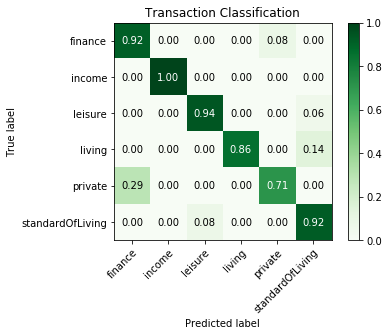

In [179]:
#create confusion matrix
matrix = confusion_matrix(yTest, yPred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
cmap = plt.cm.Greens
fig, ax = plt.subplots()
im = ax.imshow(matrix, interpolation='nearest', cmap=cmap)
ax.figure.colorbar(im, ax=ax)

#Set the axis
ax.set(xticks=np.arange(matrix.shape[1]), 
       yticks=np.arange(matrix.shape[0]), 
       xticklabels=classes, 
       yticklabels=classes, 
       title='Transaction Classification', 
       ylabel='True label', 
       xlabel='Predicted label')

#Rotate classes on x axis
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

#Text annotations inside the matrix
fmt = '.2f'
thresh = matrix.max() / 2.
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        ax.text(j, i, format(matrix[i, j], fmt), 
                ha="center", va="center", 
                color="white" if matrix[i, j] > thresh else "black")
plt.show()
#just for screenshot